# Teach an LLM to do additions

The goal of this project is to teach an LLM to do additions, playing only with two parts:
* the tokenizer
* the positional embedding

Both the model and the dataset are fixed.

You are allowed to tune the hyperparameters, but this is not the main goal. Depending on the quality of your tokenizer and positional embedding, you may change the number of bits. The initial value of 3 is very small.

In [61]:
import torch
from torch import nn
from torch.nn import functional as F

import random
import math
import re
import time

In [62]:
number_bits = 4 # numeber of additions digits

#we can only change the tokenizer and the positional embedding

dataset_size = 1_024_000
train_proportion = 0.9

log_interval = 200
batch_size = 256
epochs = 5
learning_rate = 1e-3

## Step 1: Construct a tokenizer

In [63]:
pad_token="[PAD]"
eos_token="[EOS]"

### Baseline: character-level tokenizer

In [64]:
class character_level_tokenizer:
    """
    character-level
    """
    def __init__(self):
        self.vocab = [str(x) for x in range(10)] + ["+", "="] + [pad_token, eos_token]
        self.token_to_id = {v : k for k, v in enumerate(self.vocab)}
        self.id_to_token = {k : v for k, v in enumerate(self.vocab)}
        self.ntokens = len(self.vocab)
        self.pattern = f"[^{re.escape(''.join(self.vocab))}]"

    def clean(self, text):
        """
        removes all characters not in the vocabulary
        """
        out = re.sub(self.pattern, "", text)
        return out

    def pre_tokenization(self, text):
        """
        character-level
        """
        return [c for c in text]

    def encode(self, text):
        text_list = self.pre_tokenization(self.clean(text))
        return [self.token_to_id[c] for c in text_list]

    def decode(self, token_list):
        return "".join([self.id_to_token[x] for x in token_list])

In [65]:
prompt = "12 + 34 ="
tokenizer = character_level_tokenizer()
input = tokenizer.encode(prompt)
input, [tokenizer.decode([x]) for x in input], tokenizer.decode(input)

([1, 2, 10, 3, 4, 11], ['1', '2', '+', '3', '4', '='], '12+34=')

In [66]:
tokenizer = character_level_tokenizer()
ntokens = tokenizer.ntokens
ntokens

14

## Step 2: Create a dataset for arithmetic operations

In [67]:
def sample_datapoint(number_bits = 3):
    """
    returns a string containing two random numbers on `number_bits` many bits and their sum.
    """
    a_list = [random.randint(0, 9) for _ in range(number_bits)]
    b_list = [random.randint(0, 9) for _ in range(number_bits)]
    a_int = int("".join([str(x) for x in a_list]))
    b_int = int("".join([str(x) for x in b_list]))
    sum_int = a_int + b_int
    return (str(a_int) + "+" + str(b_int) + "=", str(sum_int))

sample_datapoint(3)

('445+385=', '830')

In [68]:
data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits))
data[:4]

[('2332+2988=', '5320'),
 ('1685+7404=', '9089'),
 ('689+1876=', '2565'),
 ('5891+1707=', '7598')]

In [69]:
data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]

len(data_train),len(data_test)

(921600, 102400)

## Step 3: Construct a model

### Basline: the classical Positional Embedding

In [70]:
class PositionalEmbedding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEmbedder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEmbedder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Implement your positional embedding here!

You can do anything. Some ideas:
* RoPE
* (randomised) FIRE
* Abacus

**!!! IMPORTANT !!!** This model of Transformers is "input first", meaning that an input is a tensor with shape
(length_prompts, batch_size)

In [71]:
class TransformerModel(nn.Transformer):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__(d_model=ninp,
                                               nhead=nhead,
                                               dim_feedforward=nhid,
                                               num_encoder_layers=nlayers)
        self.input_emb = nn.Embedding(ntoken, ninp)
        self.pos_encoder = PositionalEmbedding(ninp, dropout)
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=ninp, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
            for _ in range(nlayers)
        ])

        self.decoder = nn.Linear(ninp, ntoken)

        self.ninp = ninp
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.input_emb.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        return torch.log(torch.tril(torch.ones(sz,sz)))

    def forward(self, src):
        # src: [sequence_length, batch_size] assumed
        
        mask = self._generate_square_subsequent_mask(len(src)).to(src.device)
        src = self.input_emb(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        
        hidden_states = []
        # Pass through each encoder layer and store the hidden states.
        for layer in self.encoder_layers:
            src = layer(src, src_mask=mask)
            hidden_states.append(src)
        
        output = self.decoder(src)
        # Return both the final log probabilities and the list of hidden states.
        return F.log_softmax(output, dim=-1), hidden_states


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Please do not change these parameters!

In [73]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 16,
                         nhid = 64,
                         nlayers = 8)
model.to(device)

TransformerModel(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=128, out_features=14, bias=True)
  (input_emb): Embedding(14, 128)
  (pos_encoder): PositionalEmbedding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder_layers): ModuleL

In [74]:
class ProjectionLayer(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.proj = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        return self.proj(x)

In [76]:
def generate(model, prompts, new_tokens = 5):
    input_tensor = prompts # (length_prompts, batch_size)
    input_tensor = input_tensor.to(device)
    for _ in range(new_tokens):
        output, _ = model(input_tensor) # (length_prompts, batch_size, ntokens)
        last_output = output[-1,:,:] # (batch_size, ntokens)
        token = torch.argmax(last_output, -1).view((1,-1)) # (1, batch_size)
        input_tensor = torch.cat((input_tensor, token), 0)
    return input_tensor

In [77]:
model.eval() # this disables the droppout so it is deterministic and basically is the inference step

prompt = "2+3="
prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
output = generate(model, prompt_tensor).view((1,-1))
output, tokenizer.decode(output.tolist()[0])

(tensor([[ 2, 10,  3, 11,  4, 10,  4, 10,  4]]), '2+3=4+4+4')

In [78]:
def pad(token_list, type_list = "prompts"):
    max_length = max([len(x) for x in token_list])
    out = []
    for x in token_list:
        if type_list == "prompts":
            out.append([tokenizer.token_to_id[pad_token]] * (max_length - len(x)) + x)
        if type_list == "answers":
            out.append(x + [tokenizer.token_to_id[eos_token]] + [tokenizer.token_to_id[pad_token]] * (max_length - len(x)))
    return out, max_length

In [79]:
prompts = [tokenizer.encode("1+1="), tokenizer.encode("21+35=")]
answers = [tokenizer.encode("2"), tokenizer.encode("56")]
padded_prompts, _ = pad(prompts, "prompts")
padded_answers, _ = pad(answers, "answers")
padded_prompts, padded_answers
[tokenizer.decode(p) for p in padded_prompts], [tokenizer.decode(p) for p in padded_answers]

(['[PAD][PAD]1+1=', '21+35='], ['2[EOS][PAD]', '56[EOS]'])

In [80]:
def get_batch(split, i):
    data = data_train if split == 'train' else data_test
    prompts = [tokenizer.encode(data[i][0]) for i in range(i, i + batch_size)]
    padded_prompts, length_prompts = pad(prompts, "prompts")
    answers = [tokenizer.encode(data[i][1]) for i in range(i, i + batch_size)]
    padded_answers, length_answers = pad(answers, "answers")
    X = torch.stack([torch.tensor(x) for x in padded_prompts], 1)
    Y = torch.stack([torch.tensor(x) for x in padded_answers], 1)
    return X, Y, length_prompts, length_answers

In [81]:
X, Y, length_prompts, length_answers = get_batch("train", 243)
X.shape, Y.shape, length_prompts, length_answers

(torch.Size([10, 256]), torch.Size([6, 256]), 10, 5)

## Step 4: Evaluate

In [82]:
def evaluate():
    # Turn on evaluation mode disables dropout.
    model.eval()
    correct = 0.
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(data_test) - 1, batch_size)):
            prompts, target_answers, length_prompts, length_answers = get_batch("test", i)
            prompts = prompts.to(device) # (length_prompts, batch_size)
            target_answers = target_answers.to(device) # (length_answers + 1, batch_size)
            output = generate(model, prompts, length_answers + 1) # (length_prompts + length_answers + 1, batch_size)
            answers_tokens = output[length_prompts:, :] # (length_answers + 1, batch_size), contains tokens
            equality_test = answers_tokens == target_answers # (length_answers + 1, batch_size), contains boolean values
            correct += torch.all(equality_test, axis=0).float().sum()
        accuracy = correct / len(data_test)
    return accuracy.item()

In [83]:
evaluate()

0.0

## Step 4: Train the model (transformer)

In [84]:
def train_epoch():
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    total_loss = 0.
    start_time = time.time()
    for batch, i in enumerate(range(0, len(data_train) - 1, batch_size)):
        prompts, target_answers, length_prompts, length_answers = get_batch("train", i)
        prompts = prompts.to(device) # (length_prompts, batch_size)
        target_answers = target_answers.to(device) # (length_answers, batch_size)
        input_tensor = torch.cat((prompts, target_answers), 0) # (length_prompts + length_answers, batch_size)
        model.zero_grad()
        output, _ = model(input_tensor) # (length_prompts + length_answers, batch_size, ntokens)

        ####### ADDS EXPLANATION TO THE FOLLOWING 3 LINES OF CODE DURING TRAINING SINCE IT IS UNUSUAL
        output_answers = output[length_prompts-1:-1,:,:].reshape(-1, ntokens) # (length_answers * batch_size, ntokens)
        target_answers = target_answers.view(-1)
        loss = F.cross_entropy(output_answers, target_answers)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:5.2f} | perplexity {:8.2f}'.format(batch, len(data_train) // batch_size,
                                                                                                        elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def train():
    best_test_accuracy = None
    test_accuracy = evaluate()
    print('-' * 89)
    print('| initialisation | test accuracy {:5.2f}'.format(test_accuracy))
    print('-' * 89)
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train_epoch()
        test_accuracy = evaluate()
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | test accuracy {:5.2f}'.format(epoch, (time.time() - epoch_start_time), test_accuracy))
        print('-' * 89)
        # Save the model if the test accuracy is the best we've seen so far.
        if not best_test_accuracy or test_accuracy < best_test_accuracy:
            with open("arithmetic_modified_tuned_lens.pt", 'wb') as f:
                torch.save(model, f)
            best_test_accuracy = test_accuracy

In [85]:
epochs

5

In [86]:
train()

-----------------------------------------------------------------------------------------
| initialisation | test accuracy  0.00
-----------------------------------------------------------------------------------------
|   200/ 3600 batches | ms/batch 196.16 | loss  1.83 | perplexity     6.22
|   400/ 3600 batches | ms/batch 194.48 | loss  1.59 | perplexity     4.90
|   600/ 3600 batches | ms/batch 727.08 | loss  1.50 | perplexity     4.48
|   800/ 3600 batches | ms/batch 1013.60 | loss  1.43 | perplexity     4.19
|  1000/ 3600 batches | ms/batch 1022.93 | loss  1.39 | perplexity     4.03
|  1200/ 3600 batches | ms/batch 889.71 | loss  1.37 | perplexity     3.93
|  1400/ 3600 batches | ms/batch 1046.77 | loss  1.35 | perplexity     3.86
|  1600/ 3600 batches | ms/batch 829.09 | loss  1.33 | perplexity     3.79
|  1800/ 3600 batches | ms/batch 988.81 | loss  1.32 | perplexity     3.76
|  2000/ 3600 batches | ms/batch 1041.29 | loss  1.31 | perplexity     3.72
|  2200/ 3600 batches | ms/

In [89]:
model.eval()

for i in range(20):
    prompt, answers = data_test[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
    output = generate(model, prompt_tensor, len(answers)).view((1,-1))
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

6066+7574=13599	 actual result: 13640
7620+1382=8999	 actual result: 9002
626+55=111	 actual result: 681
2749+5275=8099	 actual result: 8024
1651+5711=7499	 actual result: 7362
6783+8232=15999	 actual result: 15015
3631+7341=10999	 actual result: 10972
4181+9333=13499	 actual result: 13514
8843+1751=10599	 actual result: 10594
3817+8048=11899	 actual result: 11865
9416+1214=10699	 actual result: 10630
3375+9296=12699	 actual result: 12671
9923+1941=11899	 actual result: 11864
3737+7915=11699	 actual result: 11652
9438+7705=17199	 actual result: 17143
7385+8448=15799	 actual result: 15833
5330+387=9179	 actual result: 5717
1354+552=6899	 actual result: 1906
1119+8792=9899	 actual result: 9911
6956+1282=8299	 actual result: 8238


## Step 4.1 Train the projection layers

In [90]:
model = torch.load("arithmetic_modified_tuned_lens.pt")
model.eval()  # or model.train() if you want to run it in training mode for projection training

C:\Users\mouad\AppData\Local\Temp\ipykernel_28604\3849813560.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("arithmetic_modified_tuned_lens.pt")


TransformerModel(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=128, out_features=14, bias=True)
  (input_emb): Embedding(14, 128)
  (pos_encoder): PositionalEmbedding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder_layers): ModuleL

In [ ]:
hidden_dim = 64  # same as your model's embedding dimension
num_layers = len(model.encoder_layers)
vocab_size=ntokens
# Create a projection layer for each encoder layer.
tuned_projections = nn.ModuleList([ProjectionLayer(128, ntokens) for _ in range(num_layers)])

optimizer_proj = torch.optim.Adam(tuned_projections.parameters(), lr=1e-3)

def train_epoch_proj():
    # Set projection layers in training mode
    tuned_projections.train()
    total_loss = 0.
    start_time = time.time()
    # Iterate over your training data as before:
    for batch, i in enumerate(range(0, len(data_train) - 1, batch_size)):
        # Get your batch (prompts, target_answers, etc.)
        prompts, target_answers, length_prompts, length_answers = get_batch("train", i)
        prompts = prompts.to(device)         # shape: [length_prompts, batch_size]
        target_answers = target_answers.to(device)  # shape: [length_answers, batch_size]
        # Concatenate prompts and answers as in your training loop
        input_tensor = torch.cat((prompts, target_answers), 0)  # shape: [length_prompts + length_answers, batch_size]
        
        # Forward pass: get only hidden states (ignore final output)
        # (Assumes your modified model returns (output, hidden_states))
        _, hidden_states = model(input_tensor)
        
        # Compute loss using projections from each encoder layer
        loss = 0
        for layer_idx, hidden in enumerate(hidden_states):
            # Each hidden has shape [seq_length, batch_size, model.ninp]
            proj_logits = tuned_projections[layer_idx](hidden)  # shape: [seq_length, batch_size, ntoken]
            # Select the same token positions as in your original training:
            # Here we use tokens from position (length_prompts-1) to the one before the end.
            proj_output_answers = proj_logits[length_prompts-1:-1, :, :].reshape(-1, ntokens)
            loss += F.cross_entropy(proj_output_answers, target_answers.view(-1))
        
        optimizer_proj.zero_grad()
        loss.backward()
        optimizer_proj.step()
        
        total_loss += loss.item()
        
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| [Projection] {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:5.2f}'.format(
                batch, len(data_train) // batch_size,
                elapsed * 1000 / log_interval, cur_loss))
            total_loss = 0
            start_time = time.time()

def train_proj():
    num_epochs_proj = 5  # Set your projection training epochs
    for epoch in range(1, num_epochs_proj+1):
        epoch_start_time = time.time()
        train_epoch_proj()
        print('-' * 89)
        print('| [Projection] end of epoch {:3d} | time: {:5.2f}s'.format(
            epoch, (time.time() - epoch_start_time)))
        print('-' * 89)


In [ ]:
train_proj()

| [Projection]   200/ 3600 batches | ms/batch 365.38 | loss 12.98
| [Projection]   400/ 3600 batches | ms/batch 870.95 | loss 11.39
| [Projection]   600/ 3600 batches | ms/batch 309.75 | loss 11.23
| [Projection]   800/ 3600 batches | ms/batch 808.97 | loss 11.15
| [Projection]  1000/ 3600 batches | ms/batch 707.16 | loss 11.10
| [Projection]  1200/ 3600 batches | ms/batch 959.11 | loss 11.06
| [Projection]  1400/ 3600 batches | ms/batch 791.62 | loss 11.03
| [Projection]  1600/ 3600 batches | ms/batch 878.64 | loss 11.00
| [Projection]  1800/ 3600 batches | ms/batch 952.63 | loss 10.98
| [Projection]  2000/ 3600 batches | ms/batch 897.75 | loss 10.96
| [Projection]  2200/ 3600 batches | ms/batch 949.30 | loss 10.94
| [Projection]  2400/ 3600 batches | ms/batch 968.26 | loss 10.93
| [Projection]  2600/ 3600 batches | ms/batch 968.53 | loss 10.91
| [Projection]  2800/ 3600 batches | ms/batch 709.85 | loss 10.90
| [Projection]  3000/ 3600 batches | ms/batch 931.63 | loss 10.89
| [Project

In [103]:
def plot_projection_similarity_heatmap():
    num_layers = len(tuned_projections)
    similarities = torch.zeros((num_layers, num_layers))
    
    for i in range(num_layers):
        for j in range(num_layers):
            weight_i = tuned_projections[i].proj.weight.view(-1)
            weight_j = tuned_projections[j].proj.weight.view(-1)
            similarities[i, j] = F.cosine_similarity(weight_i, weight_j, dim=0)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(similarities.numpy(), cmap="coolwarm", annot=True, xticklabels=range(1, num_layers+1), yticklabels=range(1, num_layers+1))
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    plt.title("Projection Layer Similarity")
    plt.show()

# Example usage:
plot_projection_similarity_heatmap()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

<Figure size 600x600 with 0 Axes>

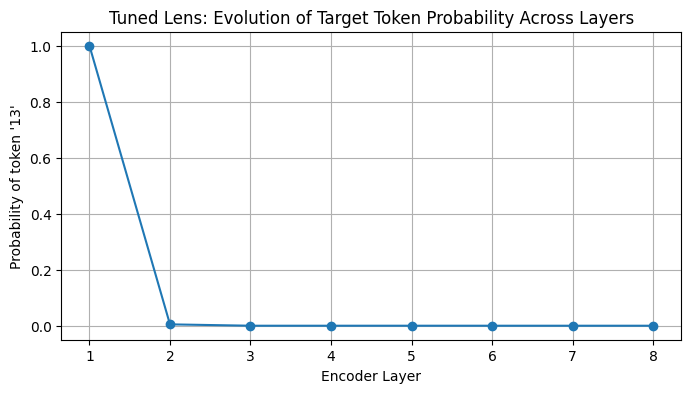

In [104]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_tuned_lens(test_input, target_sequence, target_position=5):
    """
    test_input: Tensor of shape [seq_length, batch_size] (transposed if necessary)
    target_sequence: Tensor of shape [seq_length, batch_size]
    target_position: the token index (within the sequence) to inspect.
    """
    model.eval()
    tuned_projections.eval()
    
    # Forward pass through the model to get hidden states.
    # test_input should match your model's expected input shape.
    _, hidden_states = model(test_input)
    
    # Get the target token id at the specified position.
    # Here we assume a batch size of 1 for simplicity.
    target_token = target_sequence[target_position, 0].item()
    
    layer_probs = []
    
    # For each layer's hidden state, compute the projection logits and then the softmax.
    for i, hidden in enumerate(hidden_states):
        # hidden: [seq_length, batch_size, model.ninp]
        proj_logits = tuned_projections[i](hidden)  # shape: [seq_length, batch_size, ntoken]
        # Compute softmax to get probabilities.
        probs = F.softmax(proj_logits, dim=-1)
        # Extract probability for the target token at the chosen position.
        prob = probs[target_position, 0, target_token].item()
        layer_probs.append(prob)
    
    # Plot the evolution of the probability across layers.
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(layer_probs) + 1), layer_probs, marker='o')
    plt.xlabel("Encoder Layer")
    plt.ylabel(f"Probability of token '{target_token}'")
    plt.title("Tuned Lens: Evolution of Target Token Probability Across Layers")
    plt.xticks(range(1, len(layer_probs) + 1))
    plt.grid(True)
    plt.show()

# Example usage:
# Suppose you fetch a test batch using your get_batch method:
prompts, target_answers, length_prompts, length_answers = get_batch("test", 0)
# Concatenate as during training:
input_tensor = torch.cat((prompts, target_answers), 0).to(device)
# Transpose if your model expects [seq_length, batch_size]:
input_tensor = input_tensor  # assuming it's already in the proper shape, otherwise: input_tensor = input_tensor.t()

# Similarly, prepare target_sequence.
target_sequence = target_answers.to(device)
target_sequence = target_sequence  # adjust if necessary

visualize_tuned_lens(input_tensor, target_sequence, target_position=5)

In [102]:
def plot_hidden_activation_heatmap(test_input):
    model.eval()
    
    _, hidden_states = model(test_input)
    
    num_layers = len(hidden_states)
    seq_length = test_input.shape[0]
    
    activation_heatmap = torch.zeros(seq_length, num_layers)
    
    for layer_idx, hidden in enumerate(hidden_states):
        activation_heatmap[:, layer_idx] = torch.norm(hidden[:, 0, :], dim=-1)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(activation_heatmap.numpy(), cmap="coolwarm", xticklabels=range(1, num_layers+1), yticklabels=range(seq_length))
    plt.xlabel("Transformer Layer")
    plt.ylabel("Token Position")
    plt.title("Hidden State Activation Magnitude")
    plt.show()

# Example usage:
plot_hidden_activation_heatmap(input_tensor)

AttributeError: 'str' object has no attribute 'device'